In [76]:
!tar chvfz notebook.tar.gz

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
analysis.ipynb
play_albe.ipynb
play_restricted.ipynb
play_visualization.ipynb
playgroundV2.ipynb

gzip: stdout: No space left on device
tar: notebook.tar.gz: Wrote only 4096 of 10240 bytes
tar: Child returned status 1
tar: Error is not recoverable: exiting now


In [4]:
# Load the "autoreload" extension so that code can change
%load_ext autoreload
# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import math
import EoN
import seaborn as sns
import time

# New Imports
from ctrace.contact_tracing import *
from ctrace.constraint import *
from ctrace.solve import *
from ctrace.simulation import *
from ctrace.restricted import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
G2 = nx.Graph()
G2.NAME = "able"
nodes = {}
rev_nodes = []

file = open("../data/undirected_albe_1.90.txt", "r")
file.readline()
lines = file.readlines()
c = 0
c_node=0

for line in lines:

    a = line.split()
    u = int(a[1])
    v = int(a[2])

    if u in nodes.keys():
        u = nodes[u]
    else:
        nodes[u] = c_node
        rev_nodes.append(u)
        u = c_node
        c_node+=1        
    
    if v in nodes.keys():
        v = nodes[v]
    else:
        nodes[v] = c_node
        rev_nodes.append(v)
        v = c_node
        c_node+=1

    G2.add_edge(u,v)

In [ ]:
r_mdp(G=G2, 
      p=.1, 
      budget=2000, 
      method="rrandom", 
      MDP_iterations=-1, 
      num_shocks=15, 
      num_initial_infections=9, 
      initial_iterations=5, 
      iterations_to_recover=1,
      rev_nodes=rev_nodes, 
      cache=None, 
      from_cache='a5.json',
      verbose=True,
      visualization=True)

<======= SIR Initialization Complete =======>
6 126839 3004 1376 3004
7 117877 7291 4380 7291
8 103614 12706 11671 12706
9 84211 17931 24377 17931
10 66613 16274 42308 16274


In [57]:
def r_get_prob(G:nx.graph, I, R, k, p):
    df = pd.read_csv("../data/cville_dem.txt")
    V_1, V_2 = find_excluded_contours(G,I,R)

    unique = df['age_group'].unique()
    map_label = {}

    for i, group in enumerate(unique):
        map_label[group] = i

    #print(map_label)

    labels = {i: map_label[df[df.pid==rev_nodes[i]]['age_group'].item()] for i in V_1}
    label_limits = [0,0,0,0,0]

    for i in V_1:
        label_limits[labels[i]]+=1
    
    if len(V_1) != 0:
        label_limits = k*np.array(label_limits)/len(V_1)
    label_limits = np.floor(label_limits)
    #print(label_limits)

    P, Q = PQ_deterministic(G,I,V_1,p)

    prob = ProbMinExposedRestricted(G=G,
                                    infected=I,
                                    contour1=V_1, 
                                    contour2=V_2,
                                    p1=P,
                                    q=Q,
                                    k=k,
                                    labels=labels,
                                    label_limits=label_limits,
                                    costs=[1 for _ in range(len(G.nodes))])

    return prob

In [30]:
def r_dependent(prob: ProbMinExposedRestricted):

    prob.solve_lp()
    probabilities = prob.getVariables()

    soln = np.array([0.0 for _ in range(len(probabilities))])

    for l in range(len(prob.label_limits)):
        partial_soln = np.array([probabilities[i] if prob.labels[prob.quaran_map[i]]==l else 0 for i in range(len(probabilities))])
        partial_soln = D_prime(partial_soln)

        soln += partial_soln
    
    for (k, v) in enumerate(soln):
        prob.setVariable(k,v)

    prob.solve_lp()
    
    return (prob.objectiveVal, prob.quarantined_solution)

In [34]:
prob = r_get_prob(G2, I, [], k, p)

In [ ]:
b=0
c=0
for i in range(10):
    a = r_mdp(G=G2, 
      p=.1, 
      budget=2000, 
      method="rrandom", 
      MDP_iterations=-1, 
      num_shocks=15, 
      num_initial_infections=9, 
      initial_iterations=5, 
      iterations_to_recover=1,
      rev_nodes=rev_nodes, 
      cache=None, 
      from_cache='a5.json',
      verbose=True,
      visualization=True)
    c+= a[0]
    b += a[1]
    
print(b,c)

In [ ]:
c=0
b=0
for i in range(10):
    a=generalized_mdp(G=G2, 
      p=.1, 
      budget=2000, 
      method="random", 
      MDP_iterations=-1, 
      num_shocks=15, 
      num_initial_infections=9, 
      initial_iterations=5, 
      iterations_to_recover=1,
      cache=None, 
      from_cache='a5.json',
      verbose=True,
      visualization=True)
    c+=a[0]
    b+=a[1]
print(b,c)

In [95]:
def r_greedy(prob: ProbMinExposedRestricted):
    
    sol = {}
    
    for l in range(len(prob.label_limits)):
        
        members = list(filter(lambda x: prob.labels[x] == l, prob.V1))
        
        weights: List[Tuple[int, int]] = []
        for u in members:
            w_sum = 0
            for v in set(prob.G.neighbors(u)):
                if v in prob.V2:
                    w_sum += prob.q[u][v]
            weights.append((prob.p1[u] * w_sum, u))
        # Get the top k (cost_constraint) V1s ranked by w_u = p_u * sum(q_uv for v in v2)
        weights.sort(reverse=True)
        topK = weights[:int(prob.label_limits[l])]
        topK = {i[1] for i in topK}
        
        for u in members:
            if u in topK:
                sol[u] = 1
            else:
                sol[u] = 0
    
    return (-1, sol)
        

In [94]:
sum(r_greedy(prob)[1].values())

998

In [113]:
def r_random(prob: ProbMinExposedRestricted):
    
    sol = {}
    
    for l in range(len(prob.label_limits)):
        
        members = list(filter(lambda x: prob.labels[x] == l, prob.V1))
        
        topK = random.sample(members,int(prob.label_limits[l]))
        
        for u in members:
            if u in topK:
                sol[u] = 1
            else:
                sol[u] = 0
    
    return (-1, sol)

In [115]:
#r_random(prob)

In [96]:
def to_q(G, I, R, budget, method, p):
    
    prob = r_get_prob(G, I, R, budget, p)
    
    if method == "rrandom":
        return (-1, r_random(prob))
    elif method == "rweighted":
        return r_greedy(prob)
    elif method == "rdependent":
        return r_dependent(prob)
    else:
        raise ValueError("invalid method")
        

In [52]:
def r_mdp(G: nx.graph,
        p: float,  # Required
        budget: int,  # Required
        method: str,  # Required
        MDP_iterations: int,
        num_shocks: int,  # Required
        num_initial_infections: int,
        initial_iterations: int,  # Data
        rev_nodes,
        iterations_to_recover: int = 1,  # Required
        cache: str = None,  # Data
        from_cache: str = None,
        shock_MDP: bool = False,  # Required
        visualization: bool = False,  # Required
        verbose: bool = False,
        **kwargs):  # Required   
    S = set()
    I = set()
    R = set()
    infected_queue = []

    x = []
    y1 = []
    y2 = []
    y3 = []
    
    # Data set up
    if from_cache:
        with open(PROJECT_ROOT / "data" / "SIR_Cache" / from_cache, 'r') as infile:
            j = json.load(infile)
            (S, infected_queue, R) = (
                set(j["S"]), j["I_Queue"], set(j["R"]))

            # Make infected_queue a list of sets
            infected_queue = [set(s) for s in infected_queue]
            I = I.union(*infected_queue)
            if len(infected_queue) != iterations_to_recover:
                raise ValueError(
                    "Infected queue length must be equal to iterations_to_recover")

    else:
        # initialize S, I, R
        I = set(random.sample(range(len(G.nodes)), num_initial_infections))
        S = set([i for i in range(len(G.nodes))]).difference(I)
        R = set()

        # initialize the queue for recovery
        infected_queue = [set() for _ in range(iterations_to_recover)]
        infected_queue.pop(0)
        infected_queue.append(I)
        
        if visualization:
            x.append(0)
            y1.append(len(R))
            y2.append(len(I))
            y3.append(len(S))
    
        if verbose:
            print(0, len(S), len(I), len(R))

        for t in range(initial_iterations):

            full_data = EoN.basic_discrete_SIR(G=G, p=p, initial_infecteds=I, initial_recovereds=R, tmin=0, tmax=1, return_full_data=True)

            # update susceptible, infected, and recovered sets
            S = set([k for (k, v) in full_data.get_statuses(time=1).items() if v == 'S'])
            new_I = set([k for (k, v) in full_data.get_statuses(time=1).items() if v == 'I'])

            (S, new_I) = shock(S, new_I, num_shocks)

            to_recover = infected_queue.pop(0)
            infected_queue.append(new_I)

            I = I.difference(to_recover)
            I = I.union(new_I)
            R = R.union(to_recover)
            
            if visualization:
                x.append(t+1)
                y1.append(len(R))
                y2.append(len(I))
                y3.append(len(S))
        
            if verbose:
                print(t+1, len(S), len(I), len(R), len(new_I))

    if cache:
        save = {
            "S": list(S),
            # convert list of sets into list of queue
            "I_Queue": [list(s) for s in infected_queue],
            "R": list(R),
        }
        with open(PROJECT_ROOT / "data" / "SIR_Cache" / cache, 'w') as outfile:
            json.dump(save, outfile)

    # Running the simulation
    peak = 0
    total_iterated = 0
    Q_infected = []
    Q_susceptible = []

    if MDP_iterations == -1:
        iterator = itertools.count(start=0, step=1)
    else:
        iterator = range(MDP_iterations)

    if verbose:
        print("<======= SIR Initialization Complete =======>")

    for t in iterator:

        # get recommended quarantine
        (val, recommendation) = to_q(G, I, R, budget, method=method, p=p)

        # go through one step of the disease spread
        # (S, I, R) = MDP_step(G, S, I, R, Q_infected, Q_susceptible, p=p)

        full_data = EoN.basic_discrete_SIR(G=G, p=p, initial_infecteds=I, initial_recovereds=list(
            R) + Q_infected + Q_susceptible, tmin=0, tmax=1, return_full_data=True)

        S = set([k for (k, v) in full_data.get_statuses(
            time=1).items() if v == 'S'])
        new_I = set([k for (k, v) in full_data.get_statuses(
            time=1).items() if v == 'I'])

        if shock_MDP:
            (S, new_I) = shock(S, new_I, num_shocks)

        to_recover = infected_queue.pop(0)
        infected_queue.append(new_I)

        I = I.difference(to_recover)
        I = I.union(new_I)
        R = R.union(to_recover)

        if visualization:
            x.append(len(x)+1)
            y1.append(len(R))
            y2.append(len(I))
            y3.append(len(S))
        
        if verbose:
            print(t+initial_iterations+1,len(S), len(I), len(R), len(new_I))
        
        if len(I) > peak:
            peak = len(I)
        
        # Loop until no infected left.
        if (MDP_iterations == -1) & (len(I) == 0):
            total_iterated = t + initial_iterations + 1
            break
        
        # people are quarantined (removed from graph temporarily after the timestep)
        for (k, v) in recommendation.items():
            if v == 1:
                if k in S:
                    S.remove(k)
                    Q_susceptible.append(k)
                elif k in I:  # I_t is undefined
                    I.remove(k)
                    Q_infected.append(k)
    
    #while 
    
    if visualization:
        colors = ["red", "limegreen", "deepskyblue"]
        labels = ["Infected", "Recovered", "Susceptible"]

        fig, ax = plt.subplots()
        ax.stackplot(x, y2, y1, y3, labels=labels, colors=colors)
        ax.legend(loc='upper left')
        ax.set_title("Epidemic Simulation; Quarantine Method: " + method)
        ax.set_xlabel("Timestep")
        ax.set_ylabel("Number of People")
        plt.show()
    
    return SIM_RETURN(len(R), peak, total_iterated)

# All The Plots

## Random Cville Plots showing that something may be broken

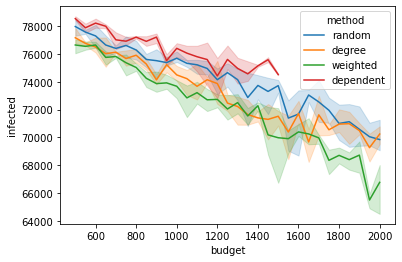

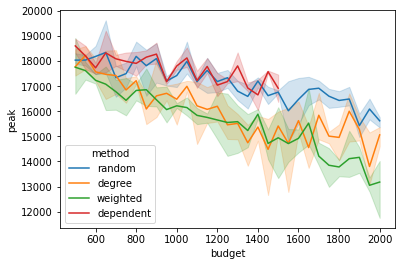

In [80]:
df = pd.read_csv("../output/run[mzPxQ]/results.csv")

sns.lineplot(data=df,x="budget",y="infected",hue="method")
plt.show()
sns.lineplot(data=df,x="budget",y="peak",hue="method")
plt.show()


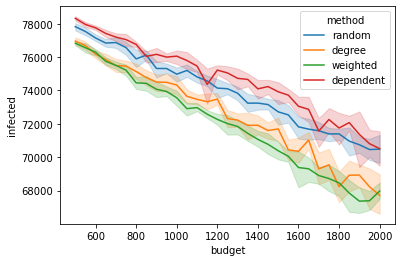

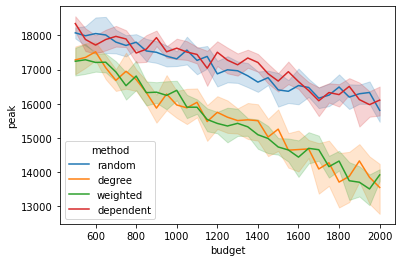

In [3]:
df = pd.read_csv("../output/run[DZQi5]/results.csv")

sns.lineplot(data=df,x="budget",y="infected",hue="method")
plt.show()
sns.lineplot(data=df,x="budget",y="peak",hue="method")
plt.show()

## Vary k, Montgomery

In [13]:
df = pd.read_csv("../output/run[358qP]/results.csv")
df1 = pd.read_csv("../output/run[hdVJE]/results.csv")
df = pd.concat([df,df1])
df = pd.concat([df[df.method == 'random'],df[df.method == 'dependent'],df[df.method == 'weighted']])
df = df.replace({'random':'Random Isolation', 'dependent':'DepRound', 'weighted':'DegGreedy'})
df['infected'] = 100.0*df['infected']/75457

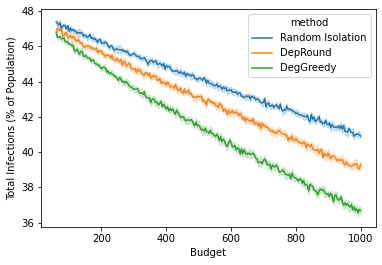

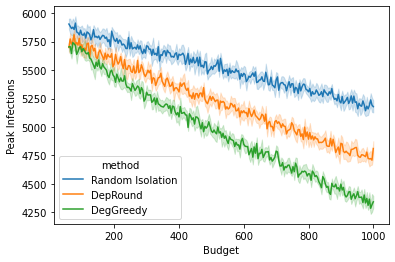

In [16]:
sns.lineplot(data=df,x="budget",y="infected",hue="method")
plt.xlabel("Budget")
plt.ylabel("Total Infections (% of Population)")
plt.show()
sns.lineplot(data=df,x="budget",y="peak",hue="method")
plt.xlabel("Budget")
plt.ylabel("Peak Infections")
plt.show()

## Vary t, Montgomery

In [49]:
df = pd.read_csv("../output/run[4iX4Y]/results.csv")
df1 = pd.read_csv("../output/run[4iX4Y]/results1.csv")
df2 = pd.read_csv("../output/run[4iX4Y]/results2.csv")
df3 = pd.read_csv("../output/run[358qP]/results.csv")
df3['budget'] = df3['budget'].replace({252:250})
df = pd.concat([df,df1,df2,df3[df3.budget==500],df3[df3.budget==250]]).reset_index(drop=True)
df['t'] = df['from_cache'].str[1:-5].astype(int)

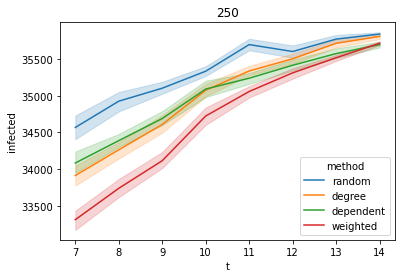

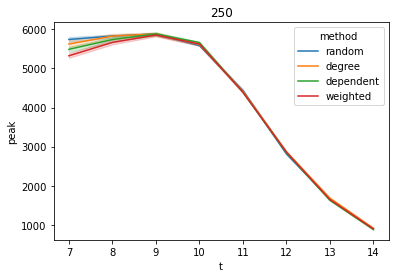

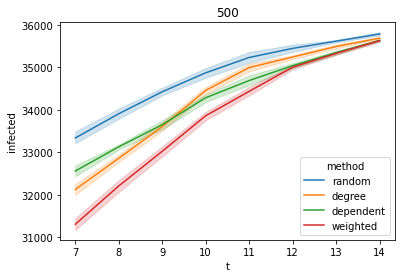

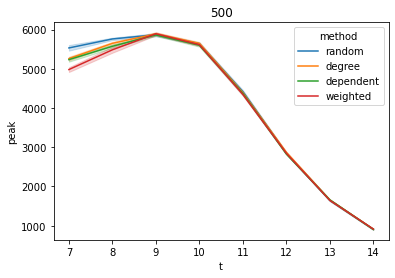

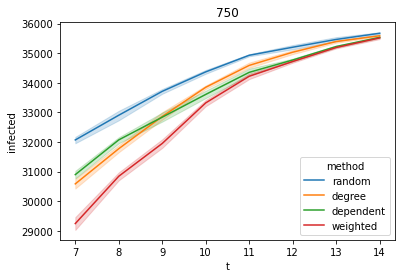

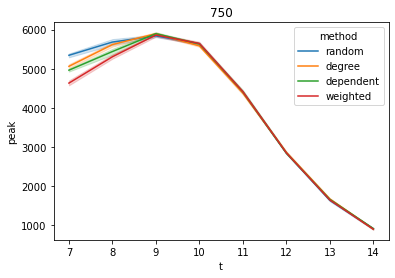

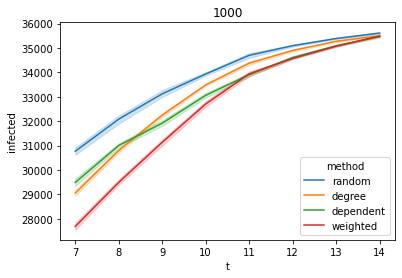

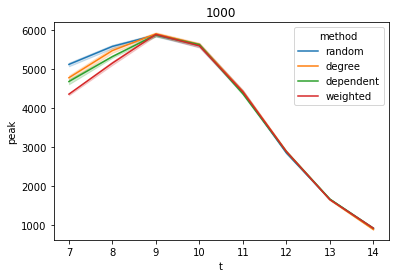

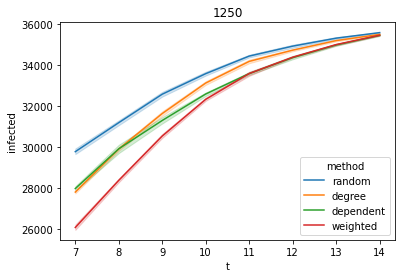

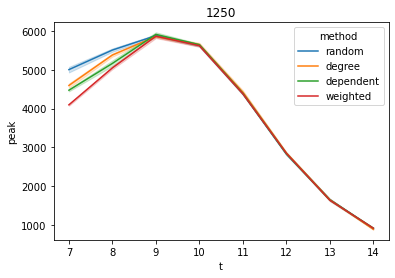

In [50]:
for k in [250,500,750,1000,1250]:
    sns.lineplot(data=df[df.budget==k],x="t",y="infected",hue="method")
    plt.title(str(k))
    plt.show()
    
    sns.lineplot(data=df[df.budget==k],x="t",y="peak",hue="method")
    plt.title(str(k))
    plt.show()

## Vary k, Charlottesville

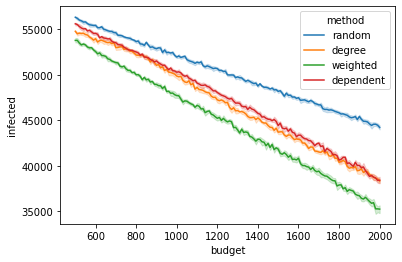

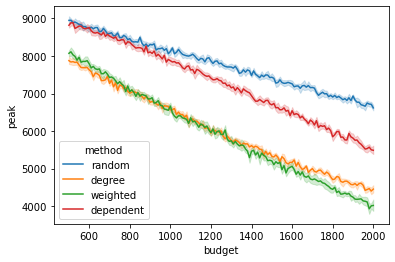

In [131]:
df = pd.read_csv("../output/run[KorCn]/results.csv")
sns.lineplot(data=df,x="budget",y="infected",hue="method")
plt.show()
sns.lineplot(data=df,x="budget",y="peak",hue="method")
plt.show()

## Vary t, Charlottesville

In [52]:
df = pd.read_csv("../output/run[DdbkN]/results.csv")
df1 = pd.read_csv("../output/run[e4GGj]/results.csv")
df = pd.concat([df,df1])
df['t'] = df['from_cache'].str[1:-5].astype(int)

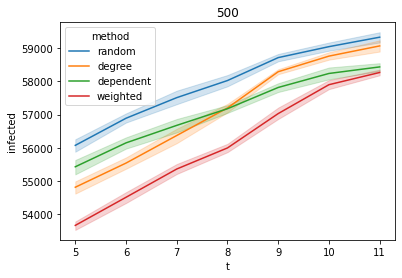

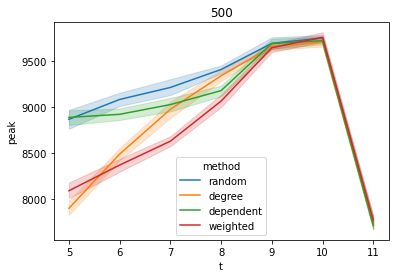

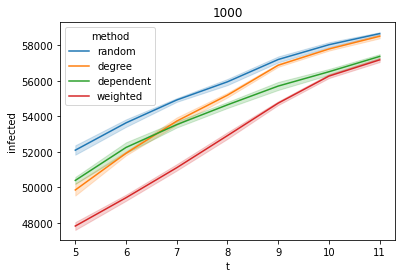

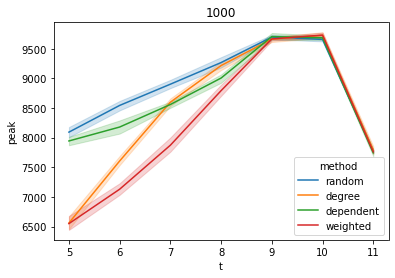

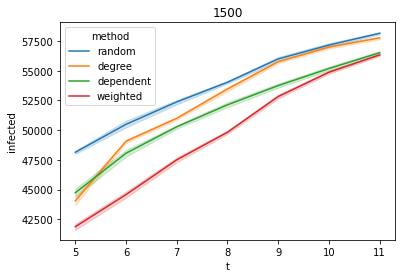

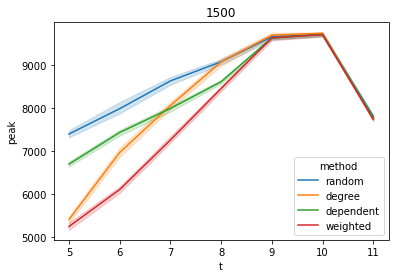

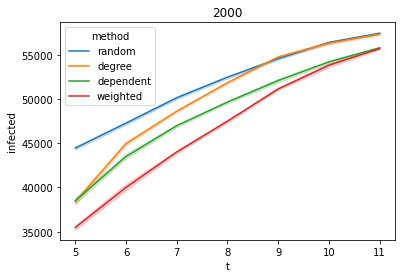

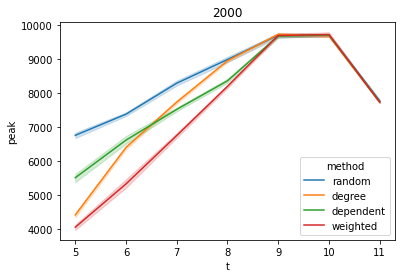

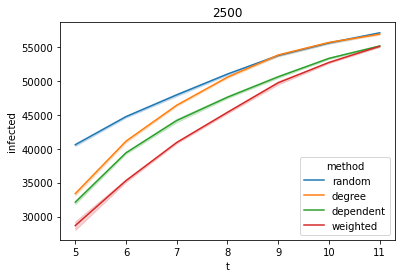

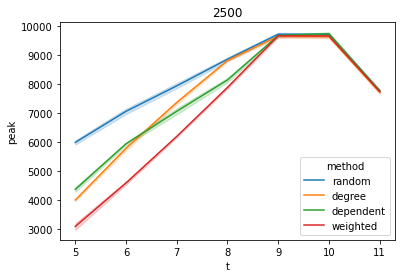

In [54]:
for k in [500,1000,1500,2000,2500]:
    sns.lineplot(data=df[df.budget==k],x="t",y="infected",hue="method")
    plt.title(str(k))
    plt.show()
    
    sns.lineplot(data=df[df.budget==k],x="t",y="peak",hue="method")
    plt.title(str(k))
    plt.show()
    

## Charlottesville Epicurve

<======= SIR Initialization Complete =======>
2 78230 5281 47708 5281
3 74941 3289 52989 3289
4 73051 1890 56278 1890
5 72080 971 58168 971
6 71611 469 59139 469
7 71332 279 59608 279
8 71189 143 59887 143
9 71115 74 60030 74
10 71067 48 60104 48
11 71044 23 60152 23
12 71031 13 60175 13
13 71028 3 60188 3
14 71024 4 60191 4
15 71023 1 60195 1
16 71022 1 60196 1
17 71021 1 60197 1
18 71020 1 60198 1
19 71020 0 60199 0


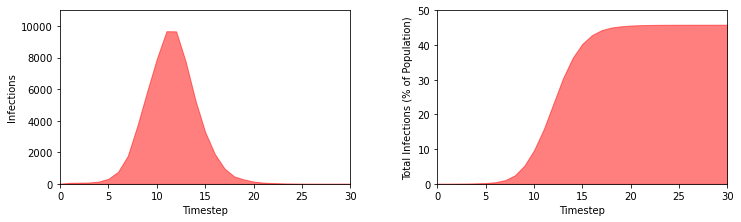

In [43]:
(x,y1,y2) = generalized_mdp(G2,
                    p = .06,  # Required
                    budget= 200,  # Required
                    method= 'none',  # Required
                    MDP_iterations= -1,
                    num_shocks=20,  # Required
                    num_initial_infections=3,
                    initial_iterations= 1,  # Data
                    iterations_to_recover= 1,  # Required
                    cache= None,  # Data
                    from_cache= "a12.json",
                    shock_MDP= False,  # Required
                    visualization= True,  # Required
                    verbose= True)  # Required


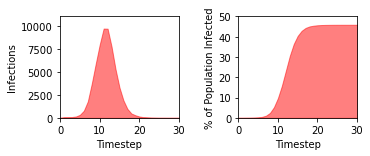

In [54]:
fig, ax = plt.subplots(1,2,figsize=(4.9,2))
fig.tight_layout()
plt.subplots_adjust(wspace = .5)
ax[0].set_xlim([0,len(y1)-1])
ax[0].set_ylim([0,11000])

ax[0].fill_between(x, y2, facecolor='red', color='red',alpha=0.5)
#ax[0].set_title("Epidemic Simulation, No Quarantine")
ax[0].set_xlabel("Timestep")
ax[0].set_ylabel("Infections")

#y1 = [100.0*i/len(G2.nodes) for i in y1]
ax[1].set_xlim([0,len(y1)-1])
ax[1].set_ylim([0,50])

ax[1].fill_between(x, y1, facecolor='red',color='red',alpha=0.5)
#ax[1].set_title("Epidemic Simulation, No Quarantine")
ax[1].set_xlabel("Timestep")
ax[1].set_ylabel("% of Population Infected")

plt.savefig("epicurves.png",dpi=500,bbox_inches = "tight")
plt.show()

In [2]:
G = load_graph('montgomery') #fetching the montgamery graph
n = len(G.nodes)
#I0 = [i for i in range(n) if random.random() > 0.99]

In [50]:
components = sorted(nx.connected_components(G), key = len, reverse=True)

In [51]:
to_rem = set()

for s in components:
    
    if len(s) <= 15:
        for node in s:
            G.remove_node(node)

In [42]:
a = list(G.nodes)

In [28]:
['a' + str(i) + ".json" for i in range(5,12,1)]

['a5.json', 'a6.json', 'a7.json', 'a8.json', 'a9.json', 'a10.json', 'a11.json']

In [78]:
['t' + str(i) + ".json" for i in range(7,15,1)]

['t7.json',
 't8.json',
 't9.json',
 't10.json',
 't11.json',
 't12.json',
 't13.json',
 't14.json']

In [75]:
nx.write_edgelist(G, "../data/portland2.txt")

In [73]:
generalized_mdp(G,
                    p = .094,  # Required
                    budget= 300,  # Required
                    method= 'none',  # Required
                    MDP_iterations= -1,
                    num_shocks=150,  # Required
                    num_initial_infections=50,
                    initial_iterations= 5,  # Data
                    iterations_to_recover= 1,  # Required
                    cache= None,  # Data
                    from_cache= None,
                    shock_MDP= False,  # Required
                    visualization= True,  # Required
                    verbose= True)  # Required

0 1233041 50 0


KeyboardInterrupt: 

In [82]:
G = load_graph("montgomery")

In [87]:
from string import ascii_lowercase

In [88]:
for c in ascii_lowercase:
    for c1 in ['a','b']:
        generalized_mdp(G,
                        p = .078,  # Required
                        budget= 1,  # Required
                        method= 'none',  # Required
                        MDP_iterations= -1,
                        num_shocks=8,  # Required
                        num_initial_infections=5,
                        initial_iterations= 5,  # Data
                        iterations_to_recover= 1,  # Required
                        cache= c+c1,  # Data
                        from_cache= None,
                        shock_MDP= False,  # Required
                        visualization= False,  # Required
                        verbose= False)  # Required


<Figure size 432x288 with 0 Axes>

In [21]:
SIM_RETURN = namedtuple("SIM_RETURN", ["num_contracted", "peak_infected", "simulation_length"])

In [81]:
def generalized_mdp(G: nx.graph,
                    p: float,  # Required
                    budget: int,  # Required
                    method: str,  # Required
                    MDP_iterations: int,
                    num_shocks: int,  # Required
                    num_initial_infections: int,
                    initial_iterations: int,  # Data
                    iterations_to_recover: int = 1,  # Required
                    cache: str = None,  # Data
                    from_cache: str = None,
                    shock_MDP: bool = False,  # Required
                    visualization: bool = False,  # Required
                    verbose: bool = False,
                    **kwargs):  # Required
    S = set()
    I = set()
    R = set()
    infected_queue = []

    x = []
    y1 = []
    y2 = []
    y3 = []
    
    # Data set up
    if from_cache:
        with open(PROJECT_ROOT / "data" / "SIR_Cache" / from_cache, 'r') as infile:
            j = json.load(infile)
            (S, infected_queue, R) = (
                set(j["S"]), j["I_Queue"], set(j["R"]))
            (x,y1,y2,y3) = (j['x'], j['y1'], j['y2'], j['y3'])
            # Make infected_queue a list of sets
            infected_queue = [set(s) for s in infected_queue]
            I = I.union(*infected_queue)
            if len(infected_queue) != iterations_to_recover:
                raise ValueError(
                    "Infected queue length must be equal to iterations_to_recover")

    else:
        # initialize S, I, R
        I = set(random.sample(list(G.nodes), num_initial_infections))
        S = set(list(G.nodes)).difference(I)
        R = set()

        # initialize the queue for recovery
        infected_queue = [set() for _ in range(iterations_to_recover)]
        infected_queue.pop(0)
        infected_queue.append(I)
        
        if visualization:
            x.append(0)
            y1.append(len(R))
            y2.append(len(I))
            y3.append(len(S))
    
        if verbose:
            print(0, len(S), len(I), len(R))

        for t in range(initial_iterations):

            full_data = EoN.basic_discrete_SIR(
                G=G, p=p+(1-p)*int(t==0), initial_infecteds=I, initial_recovereds=R, tmin=0, tmax=1, return_full_data=True)

            # update susceptible, infected, and recovered sets
            S = set([k for (k, v) in full_data.get_statuses(
                time=1).items() if v == 'S'])
            new_I = set([k for (k, v) in full_data.get_statuses(
                time=1).items() if v == 'I'])

            (S, new_I) = shock(S, new_I, num_shocks)

            to_recover = infected_queue.pop(0)
            infected_queue.append(new_I)

            I = I.difference(to_recover)
            I = I.union(new_I)
            R = R.union(to_recover)
            
            if visualization:
                x.append(t+1)
                y1.append(len(R))
                y2.append(len(I))
                y3.append(len(S))
        
            if verbose:
                print(t+1, len(S), len(I), len(R), len(new_I))

        if cache:
            save = {
                "S": list(S),
                # convert list of sets into list of queue
                "I_Queue": [list(s) for s in infected_queue],
                "R": list(R),
                "x": x,
                "y1": y1,
                "y2": y2,
                "y3": y3
            }
            name = cache + str(initial_iterations) + ".json"
            if len(I) >= 500:
                with open(PROJECT_ROOT / "data" / "SIR_Cache" / "time_trials" / name, 'w') as outfile:
                        json.dump(save, outfile)

    # Running the simulation
    peak = 0
    total_iterated = 0
    Q_infected = []
    Q_susceptible = []

    if MDP_iterations == -1:
        iterator = itertools.count(start=0, step=1)
    else:
        iterator = range(MDP_iterations)

    if verbose:
        print("<======= SIR Initialization Complete =======>")

    for t in iterator:

        # get recommended quarantine
        (val, recommendation) = to_quarantine(
            G, I, R, budget, method=method, p=p)

        # go through one step of the disease spread
        # (S, I, R) = MDP_step(G, S, I, R, Q_infected, Q_susceptible, p=p)

        full_data = EoN.basic_discrete_SIR(G=G, p=p, initial_infecteds=I, initial_recovereds=list(
            R) + Q_infected + Q_susceptible, tmin=0, tmax=1, return_full_data=True)

        S = set([k for (k, v) in full_data.get_statuses(
            time=1).items() if v == 'S'])
        new_I = set([k for (k, v) in full_data.get_statuses(
            time=1).items() if v == 'I'])

        if shock_MDP:
            (S, new_I) = shock(S, new_I, num_shocks)

        to_recover = infected_queue.pop(0)
        infected_queue.append(new_I)

        I = I.difference(to_recover)
        I = I.union(new_I)
        R = R.union(to_recover)

        if visualization:
            x.append(len(x)+1)
            y1.append(len(R))
            y2.append(len(I))
            y3.append(len(S))
        
        if verbose:
            print(t+initial_iterations+1,len(S), len(I), len(R), len(new_I))
        
        if len(I) > peak:
            peak = len(I)
        
        if cache:
            save = {
                "S": list(S),
                # convert list of sets into list of queue
                "I_Queue": [list(s) for s in infected_queue],
                "R": list(R),
                "x": x,
                "y1": y1,
                "y2": y2,
                "y3": y3
            }
            name = cache+str(t+initial_iterations+1) + ".json"
            if len(I) >= 500:
                with open(PROJECT_ROOT / "data" / "SIR_Cache" / "time_trials" / name, 'w') as outfile:
                    json.dump(save, outfile)
        
        # Loop until no infected left.
        if (MDP_iterations == -1) & (len(I) == 0):
            total_iterated = t + initial_iterations + 1
            break
        
        # people are quarantined (removed from graph temporarily after the timestep)
        for (k, v) in recommendation.items():
            if v == 1:
                if k in S:
                    S.remove(k)
                    Q_susceptible.append(k)
                elif k in I:  # I_t is undefined
                    I.remove(k)
                    Q_infected.append(k)
    
    #while 
    
    if visualization:
        colors = ["red", "limegreen", "deepskyblue"]
        labels = ["Infected", "Recovered", "Susceptible"]

        fig, ax = plt.subplots(1,2,figsize=(10,3))
        fig.tight_layout()
        plt.subplots_adjust(wspace = .3)
        ax[0].set_xlim([0,len(y1)-1])
        ax[0].set_ylim([0,11000])

        ax[0].fill_between(x, y2, facecolor='red', color='red',alpha=0.5)
        #ax[0].set_title("Epidemic Simulation, No Quarantine")
        ax[0].set_xlabel("Timestep")
        ax[0].set_ylabel("Infections")
        
        y1 = [100.0*i/len(G.nodes) for i in y1]
        ax[1].set_xlim([0,len(y1)-1])
        ax[1].set_ylim([0,50])
        
        ax[1].fill_between(x, y1, facecolor='red',color='red',alpha=0.5)
        #ax[1].set_title("Epidemic Simulation, No Quarantine")
        ax[1].set_xlabel("Timestep")
        ax[1].set_ylabel("Total Infections (% of Population)")
        
        plt.savefig("epicurves.png",dpi=500,bbox_inches = "tight")

        plt.show()
        return (x,y1,y2)
    # TODO: Check return statement
    return SIM_RETURN(len(R), peak, total_iterated)

In [23]:
fig = plt.gcf()


<Figure size 432x288 with 0 Axes>

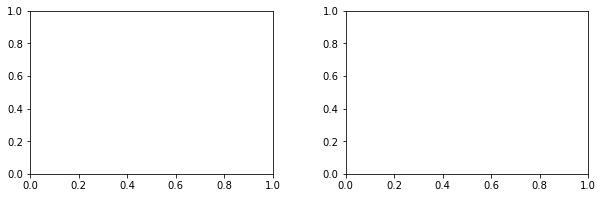

In [38]:
fig, ax = plt.subplots(1,2,figsize=(10,3))
plt.subplots_adjust(wspace = .3)
plt.show()

In [17]:
type(ax[1])

matplotlib.axes._subplots.AxesSubplot

In [5]:
S, I, R = initial(from_cache="Q4data.json")
print(len(I))

421


0 421 74686 350
1 834 73752 771
2 1727 71992 1650
3 3189 68760 3412
4 5534 63189 6643
5 8074 55067 12225
6 8618 46386 20359
7 6667 39653 29051
8 3826 35754 35783
9 1808 33886 39669
10 716 33125 41523
11 241 32842 42277
12 82 32732 42547
13 18 32695 42644


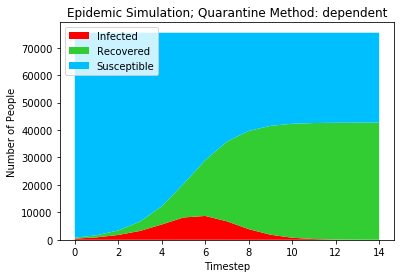

(42674, 8692, 14)

In [24]:
MDP(G, 100, S, I, R, p=0.1, iterations=-1, visualization=True, method="dependent", verbose=True)

In [8]:
df1 = pd.read_csv("../output/Q4_csvs/george_random_data.csv")
df2 = pd.read_csv("../output/Q4_csvs/george_degree_data.csv")
df3 = pd.read_csv("../output/Q4_csvs/george_dependent_data.csv")
df4 = pd.read_csv("../output/Q4_csvs/george_random_data2.csv")
df5 = pd.read_csv("../output/Q4_csvs/george_degree_data2.csv")
df6 = pd.read_csv("../output/Q4_csvs/george_dependent_data2.1.csv")
df7 = pd.read_csv("../output/Q4_csvs/george_random_data3.csv")
df8 = pd.read_csv("../output/Q4_csvs/george_degree_data3.csv")
df9 = pd.read_csv("../output/Q4_csvs/george_dependent_data3.csv")

In [16]:
print(df7.shape)
print(df8.shape)
print(df9.shape)

(40, 19)
(40, 19)
(40, 19)


In [9]:
df1 = pd.concat([df1,df4,df7]).reset_index(drop=True)
df2 = pd.concat([df2,df5,df8]).reset_index(drop=True)
df3 = pd.concat([df3,df6,df9]).reset_index(drop=True)


C:\Users\George Li\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [20]:
ks = np.array(df1['k'])
print(ks)
a=43000
b=9000
none_total = [a for _ in ks]
none_peak = [b for _ in ks]
#print(none_total)
#print(none_peak)

[ 500.  510.  520.  530.  540.  550.  560.  570.  580.  590.  600.  610.
  620.  630.  640.  650.  660.  670.  680.  690.  700.  710.  720.  730.
  740.  750.  760.  770.  780.  790.  800.  810.  820.  830.  840.  850.
  860.  870.  880.  890.  900.  910.  920.  930.  940.  950.  960.  970.
  980.  990. 1000. 1010. 1020. 1030. 1040. 1050. 1060. 1070. 1080. 1090.
 1100. 1110. 1120. 1130. 1140. 1150. 1160. 1170. 1180. 1190. 1200. 1210.
 1220. 1230. 1240. 1250. 1260. 1270. 1280. 1290. 1300. 1310. 1320. 1330.
 1340. 1350. 1360. 1370. 1380. 1390. 1400. 1410. 1420. 1430. 1440. 1450.
 1460. 1470. 1480. 1490. 1500. 1510. 1520. 1530. 1540. 1550. 1560. 1570.
 1580. 1590. 1600. 1610. 1620. 1630. 1640. 1650. 1660. 1670. 1680. 1690.
 1700. 1710. 1720. 1730. 1740. 1750. 1760. 1770. 1780. 1790. 1800. 1810.
 1820. 1830. 1840. 1850. 1860. 1870. 1880. 1890. 1900. 1910. 1920. 1930.
 1940. 1950. 1960. 1970. 1980. 1990. 2000.  100.  110.  120.  130.  140.
  150.  160.  170.  180.  190.  200.  210.  220.  2

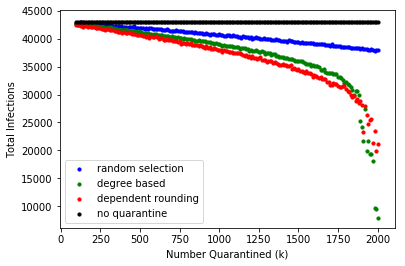

In [21]:
fig, ax = plt.subplots()

ax.scatter(df1['k'], df1['avg_total'], c='blue', s=10)

ax.scatter(df2['k'], df2['avg_total'], c='green', s=10)

ax.scatter(df3['k'], df3['avg_total'], c='red', s=10)

ax.scatter(ks, none_total, c='black', s=10)

#ax.set_title("Total Infections vs. Number Quarantined for Different Methods")
ax.set_xlabel("Number Quarantined (k)")
ax.set_ylabel("Total Infections")

ax.legend(['random selection','degree based','dependent rounding','no quarantine'])


plt.show()

#fig.savefig("../output/Q4plots/compare_total1", dpi=400)

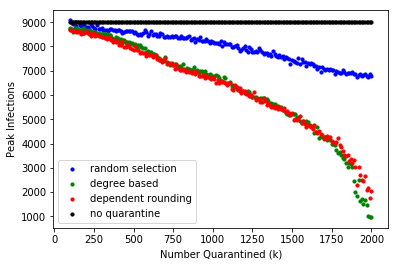

In [22]:
fig1, ax1 = plt.subplots()

ax1.scatter(df1['k'], df1['avg_peak'], c='blue', s=10)

ax1.scatter(df2['k'], df2['avg_peak'], c='green', s=10)

ax1.scatter(df3['k'], df3['avg_peak'], c='red', s=10)

ax1.scatter(ks, none_peak, c = 'black', s=10)

#ax1.set_title("Peak Infections vs. Number Quarantined for Different Methods")
ax1.set_xlabel("Number Quarantined (k)")
ax1.set_ylabel("Peak Infections")

ax1.legend(['random selection','degree based','dependent rounding', 'no quarantine'])

plt.show()

#fig1.savefig("../output/Q4plots/compare_peak1", dpi=400)

In [26]:
(S, I, R) = initial(G, from_cache="Q4data.json")

In [19]:
print(a)
b

43010.6


9062.0

0 421 74686 350
1 878 73808 771
2 1808 72000 1649
3 3532 68468 3457
4 6229 62239 6989
5 8803 53436 13218
6 8866 44570 22021
7 6243 38327 30887
8 3242 35085 37130
9 1456 33629 40372
10 619 33010 41828
11 243 32767 42447
12 86 32681 42690
13 31 32650 42776
14 11 32639 42807
15 4 32635 42818
16 2 32633 42822


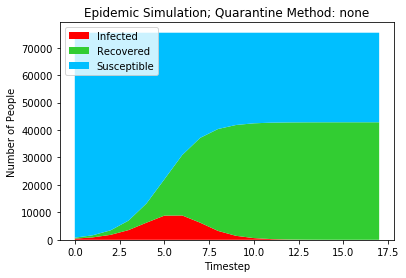

42824
8866
17
0 421 74686 350
1 961 73725 771
2 2045 71680 1732
3 4018 67662 3777
4 6782 60880 7795
5 9145 51735 14577
6 8552 43183 23722
7 5598 37585 32274
8 2888 34697 37872
9 1250 33447 40760
10 511 32936 42010
11 221 32715 42521
12 86 32629 42742
13 35 32594 42828
14 17 32577 42863
15 3 32574 42880


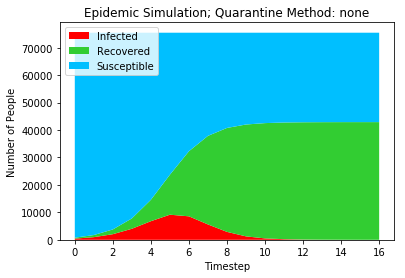

42883
9145
16
0 421 74686 350
1 914 73772 771
2 1881 71891 1685
3 3739 68152 3566
4 6647 61505 7305
5 9137 52368 13952
6 8846 43522 23089
7 5929 37593 31935
8 2907 34686 37864
9 1338 33348 40771
10 508 32840 42109
11 199 32641 42617
12 76 32565 42816
13 26 32539 42892
14 16 32523 42918
15 12 32511 42934
16 7 32504 42946
17 4 32500 42953
18 1 32499 42957


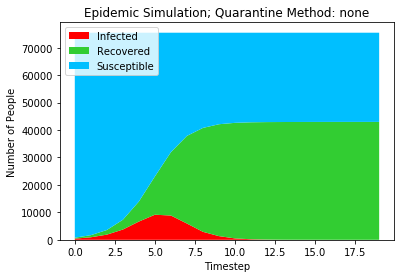

42958
9137
19
0 421 74686 350
1 900 73786 771
2 1938 71848 1671
3 3960 67888 3609
4 6762 61126 7569
5 9184 51942 14331
6 8818 43124 23515
7 5859 37265 32333
8 2952 34313 38192
9 1240 33073 41144
10 513 32560 42384
11 210 32350 42897
12 89 32261 43107
13 38 32223 43196
14 8 32215 43234
15 5 32210 43242


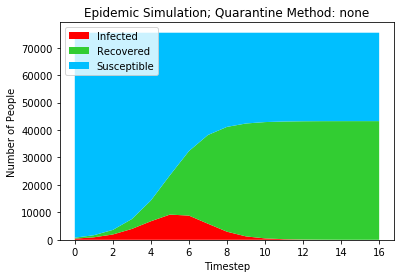

43247
9184
16
0 421 74686 350
1 895 73791 771
2 1888 71903 1666
3 3503 68400 3554
4 6263 62137 7057
5 8774 53363 13320
6 8978 44385 22094
7 6333 38052 31072
8 3240 34812 37405
9 1466 33346 40645
10 596 32750 42111
11 258 32492 42707
12 101 32391 42965
13 41 32350 43066
14 16 32334 43107
15 8 32326 43123
16 7 32319 43131
17 2 32317 43138
18 1 32316 43140


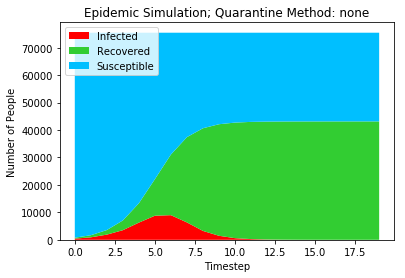

43141
8978
19


In [18]:
a = 0
b = 0

for i in range(5):
    (x,y,z) = MDP(G, 0, S, I, R, p=0.1, iterations=-1, visualization=True, method="none", verbose=True)
    a+=x
    b+=y
    
    print(x)
    print(y)
    print(z)
    
a/=5
b/=5

701 74162 594
1487 72275 1295
2741 69499 2836
4713 64751 5598
6891 57825 10350
8196 49597 17280
7086 42467 25533
4587 37834 32655
2414 35378 37277
1102 34238 39731
416 33780 40874
101 33641 41322
0 33752 41456
0 33974 41483
0 33974 41483


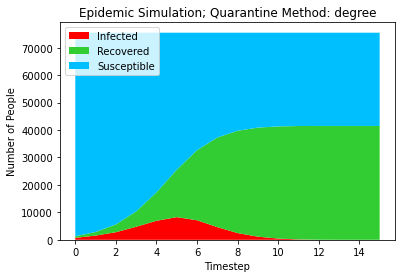

In [9]:
MDP(G, 400, S, I, R, p=0.1, iterations=15, visualization=True, method="degree")

In [5]:
import time
a = time.time()
MDP(G, 400, S, I, R, p=0.1, iterations=15, visualization=True, method="dependent", verbose=True)
print(time.time()-a)

421 74686 350


AttributeError: 'NoneType' object has no attribute 'NumVar'

In [ ]:
"""Stop here"""

In [18]:
#G = load_graph("montgomery")
n = len(G2.nodes)
I = [i for i in range(n) if random.random() > .99]

In [19]:
COSTS = np.ones(n)

In [20]:
V_1,V_2 = find_excluded_contours(G2,I,[])

In [41]:
degrees = []

for u in V_1:
    count = 0
    for v in G.neighbors(u):
        if v in V_2:
            count+=1

    degrees.append((count,u))

degrees.sort()
degrees.reverse()

sol = {}

for i in range(len(V_1)):
    if i < 100:
        sol[degrees[i][1]] = 1
    else:
        sol[degrees[i][1]] = 0

In [43]:
a = 0
for (k,v) in sol.items():
    a+=v
a

100

In [37]:
arr[:5]

[(65, 3751), (62, 27236), (61, 35651), (61, 34538), (60, 18733)]

In [101]:
P,Q = PQ_deterministic(G=G2,I=I,V1=V_1,p=0.08)

In [102]:
prob = ProbMinExposed(G2,I,V_1,V_2,P,Q,2000,COSTS)
prob.solve_lp()
prob.objectiveVal

2249.3008640055355

In [22]:
print(prob.costs.sum())

75457.0


In [24]:
a = 0
for (k,v) in prob.partials.items():
    a += v
print(a)

2877


In [103]:
a = prob.getVariables()
#print(a.sum())
(val, c) = basic_non_integer_round(prob)
#print(c.sum())
#print(val1)
print(val)
#prob = ProbMinExposed.from_dataframe(G,I0,V_1,V_2,P,Q,800,COSTS)
#(val2, b) = iterated_round(prob,100)
#prob = ProbMinExposed.from_dataframe(G,I0,V_1,V_2,P,Q,800,COSTS)
#(val3, d) = optimized_iterated_round(prob, 100)
#print(val2)
#print(val3)
#for i in range(len(a)):
#    if (a[i] != 0) & (a[i] != 1):
#        print(str(a[i]) + " " + str(c[i]))
    
#print(len(a))
#a.sum()

2388.990848003932


In [21]:
sample = random.sample(range(0, len(V_1)), 800)
#just to not break stuff
prob.solve_lp()

for u in range(0,len(V_1)):
    #print(u)
    if u in sample:
        prob.setVariable(u, 0)
    else:
        prob.setVariable(u, 1)
#print(prob.partials)
print(len(V_1))
print(len(prob.partials))
print(prob.costs)
print(len(prob.costs))
#print(prob.filled())

prob.solve_lp()

3677
3677
[1. 1. 1. ... 1. 1. 1.]
75457


ValueError: Infeasible solution

In [49]:
for (k,v) in c.items(): 
    print(k)
    print(v)
    break

32768
0.0


In [20]:
print(len(V_1))
len(b)

11298


11298

In [13]:
a1=0
a2=0
a3=0
m1=10000000000
m2=10000000000
m3=10000000000

k=20

for i in range(k):
    prob = ProbMinExposed.from_dataframe(G,I0,V_1,V_2,P,Q,800,COSTS)
    optimized_iterated_round(prob, 500)
    prob.solve_lp()
    a1 += prob.objectiveVal
    
    if prob.objectiveVal < m1:
        m1 = prob.objectiveVal
    
    prob = ProbMinExposed.from_dataframe(G,I0,V_1,V_2,P,Q,800,COSTS)
    iterated_round(prob, 500)
    prob.solve_lp()
    a2 += prob.objectiveVal
    
    if prob.objectiveVal < m2:
        m2 = prob.objectiveVal

    prob = ProbMinExposed.from_dataframe(G,I0,V_1,V_2,P,Q,800,COSTS)
    basic_non_integer_round(prob)
    prob.solve_lp()
    a3 += prob.objectiveVal
        
    if prob.objectiveVal < m3:
        m3 = prob.objectiveVal
    
    print(i)
    
a1 /= k
a2 /= k
a3 /= k

print("Average: " + str(a1) + " " + str(a2) + " " + str(a3))
print("Best: " + str(m1) + " " + str(m2) + " " + str(m3))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Average: 13995.412500000286 13970.625000000266 14023.225000000264
Best: 13966.450000000283 13950.600000000224 13992.000000000284


In [8]:
#p1 = defaultdict(lambda: .7)
#q = defaultdict(lambda: defaultdict(lambda : .7))
#prob = ProbMinExposed(G,I0,V_1,V_2,p1,q,10,COSTS)

In [ ]:
#test simplify

a = 1
b = 0

total_a = 0
total_b = 0

n=1000000

for i in range(n):
    (x,y,new_a,new_b) = simplify(a,b)
    
    if x==-1:
        total_a += new_a
        total_b += y
    elif y==-1:
        total_a += x
        total_b += new_b
    else:
        total_a += x
        total_b += y

print(str(total_a/n) + " " + str(a))
print(str(total_b/n) + " " + str(b))

In [ ]:
#test D
p = [.5,.5,.25,.6,.15]

n=10000
total = np.zeros(5)

for i in range(n):
    a = D(p)
    if np.sum(a) != np.sum(p):
        print("oof")
    #print(p)
    total += a
    
total/=n
print(total)

In [ ]:
#test D_prime
p = [.5,.4,.25,.75,.7]

n=5000
total = np.zeros(5)

for i in range(n):
    a = D(p)
    if (np.sum(a) != math.floor(np.sum(p))) & (np.sum(a) != math.ceil(np.sum(p))):
        print("oof")
    #print(p)
    total += a
    
total/=n
print(total)